# Detecting Text in Signs

The detection follows the steps:
1. Read an image
2. Turn the image into grayscales 
3. Blur the image to reduce noise, by using GaussianBlur
4. Binarize the image with a simple or an adaptive threshold
5. Detect shapes
6. Assert that there's some content into the detected shape

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

Firstly, read the image using OpenCV2 and plot it using Matplotlib

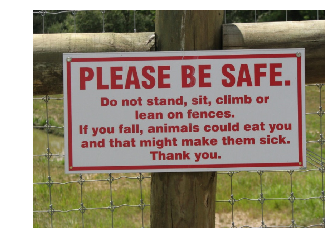

In [5]:
imgName = 'imgs/img_883.jpg'
regularImg = cv2.imread(imgName)
plt.imshow(cv2.cvtColor(regularImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Changing it to grayscale and blurring it a bit

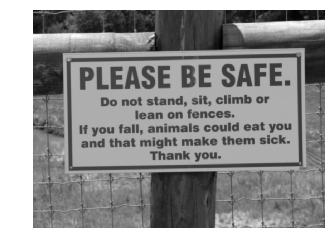

In [7]:
grayImg = cv2.cvtColor(regularImg, cv2.COLOR_BGR2GRAY);
blurredImg = applyBlurToImg(grayImg)
plt.imshow(blurredImg, cmap='gray')
plt.axis('off');

Then, binarizing the image

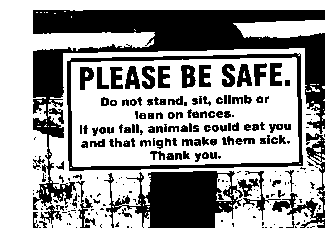

In [8]:
binaryImg = getBinaryImg(blurredImg)
plt.imshow(binaryImg, cmap='gray')
plt.axis('off');

Since this image has a plate with several edges, it's easy to detect them. There is the bounding box

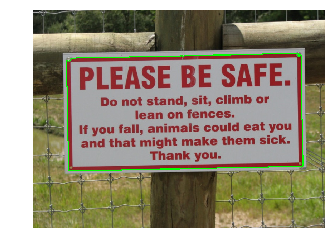

In [9]:
bestContour = getBestContour(binaryImg)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Now there is the crop, and we are done with this image

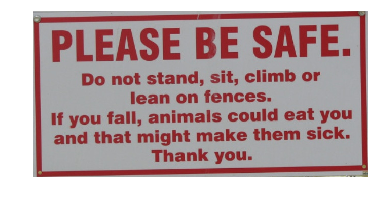

In [10]:
croppedImg = cropImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(croppedImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Now, for a slightly different scenario, let's use another image as input

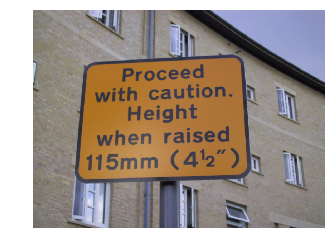

In [11]:
imgName = 'imgs/117_icdar13.png'
regularImg = cv2.imread(imgName)
plt.imshow(cv2.cvtColor(regularImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Using the same methods and parameters as above

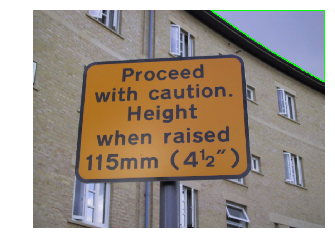

In [12]:
grayImg = cv2.cvtColor(regularImg, cv2.COLOR_BGR2GRAY);
blurredImg = applyBlurToImg(grayImg)
binaryImg = getBinaryImg(blurredImg)
bestContour = getBestContour(binaryImg)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)

plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

What went wrong? Let's check the binarized image

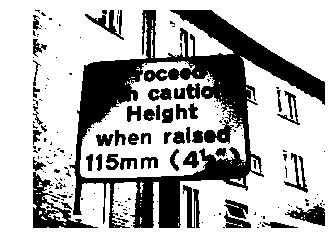

In [13]:
plt.imshow(binaryImg, cmap='gray')
plt.axis('off');

The top-right edge of the plate got mixed up with the buildings roof. That is because the region between those two things is a bit darker than our threshold for binarization. So, let's try a lower alpha value

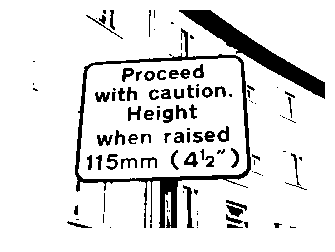

In [14]:
binaryImg = getBinaryImg(blurredImg, alpha = 0.75)
plt.imshow(binaryImg, cmap='gray')
plt.axis('off');

Now we can see the plate's edges clearly. Continuing...

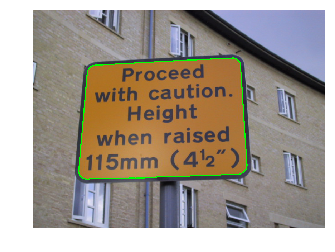

In [15]:
bestContour = getBestContour(binaryImg)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

And cropping...

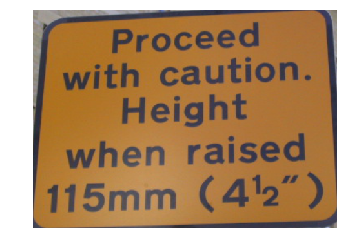

In [16]:
croppedImg = cropImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(croppedImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Now, a harder case to solve

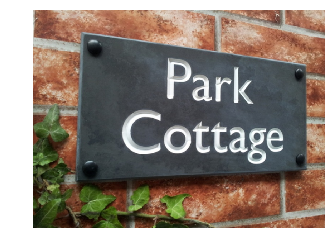

In [17]:
imgName = 'imgs/img_1020.jpg'
regularImg = cv2.imread(imgName)
plt.imshow(cv2.cvtColor(regularImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

When coloured, it seems like another easy case, but when turning it into greyscale, the colours of the plate and the wall look too similar

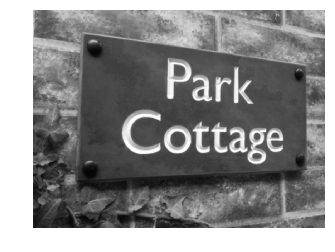

In [18]:
grayImg = cv2.cvtColor(regularImg, cv2.COLOR_BGR2GRAY);
blurredImg = applyBlurToImg(grayImg)
plt.imshow(cv2.cvtColor(blurredImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Let's try different values of alpha for binarization and see how it goes

The alpha values will increase by 0.1 from 0.6 to 1.4

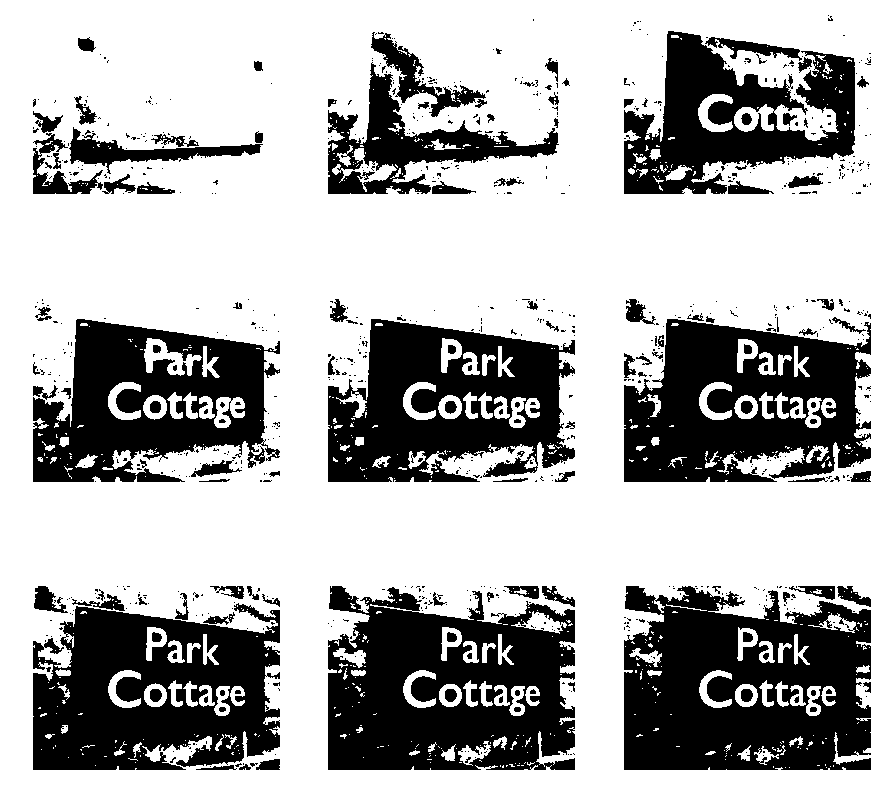

In [19]:
h = w = 10
fig = plt.figure(figsize=(15, 15))
rows = cols = 3
blurredImg = np.uint8(blurredImg)
for i in range(1, cols*rows +1):
    img = getBinaryImg(blurredImg, alpha=0.5 + 0.10*i)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

None of these binarizations seem friendly. That means, no matter what value of alpha we use, there will be no scenario in which the background wall will be separated from the plate.

But looking back at the coloured image, we can clearly see that the plate has a dark grey colour, the wall is reddish brown and there are some green leaves too. So what if we try to proccess it separatedly for each colour channel?

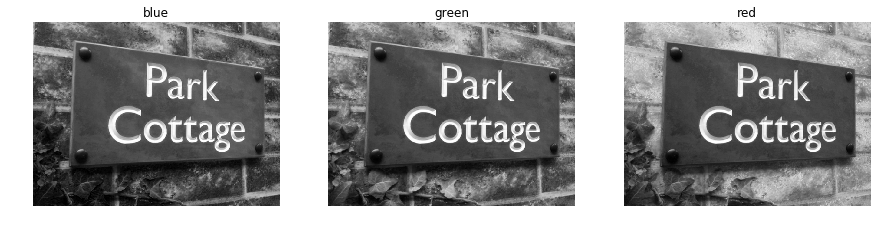

In [20]:
fig = plt.figure(figsize=(15, 15))
rows = 1
colours = ['blue', 'green', 'red']
for i in range(1, cols*rows +1):
    singleChannelImg = regularImg[:,:,i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(singleChannelImg, cmap='gray')
    plt.title(colours[i-1])
    plt.axis('off')
plt.show()

The wall on the red channel is way lighter than on the blue and green. So, the binarization there will be easier. We just need to find an alpha that fits our needs

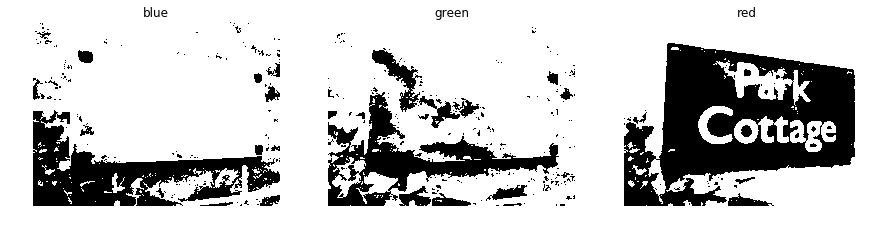

In [21]:
singleChannelImgs = [regularImg[:,:,0], regularImg[:,:,1], regularImg[:,:,2]]
blurredImgs = [applyBlurToImg(img) for img in singleChannelImgs]
binaryImgs = [getBinaryImg(img, alpha=0.7) for img in blurredImgs]

fig = plt.figure(figsize=(15, 15))
for i in range(1, cols*rows +1):
    binaryImg = binaryImgs[i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(binaryImg, cmap='gray')
    plt.title(colours[i-1])
    plt.axis('off')
plt.show()

Trying to get the best contour now

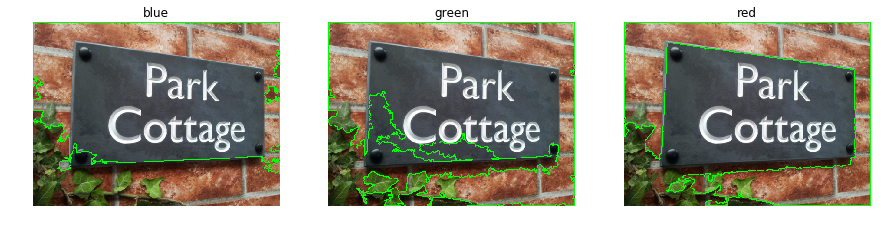

In [22]:
bestContours = [getBestContour(img, maxVertex=100) for img in binaryImgs]
fig = plt.figure(figsize=(15, 15))
for i in range(1, cols*rows +1):
    regularImgWithDetection = applyDetectionToImg(regularImg, bestContours[i-1])
    fig.add_subplot(rows, cols, i)
    plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title(colours[i-1])
    plt.axis('off')
plt.show()

This approach didn't show great improvement, since the plate contour is not being captured. If it were, we could set the maximum amount of vertices to 4 (or another close value), so the largest contoured area selected would not be the wall on the background.

Let's try switching the threshold method to Adaptive Threshold now.

Using the block size = 9 and increasing the constant to be subtracted from the image

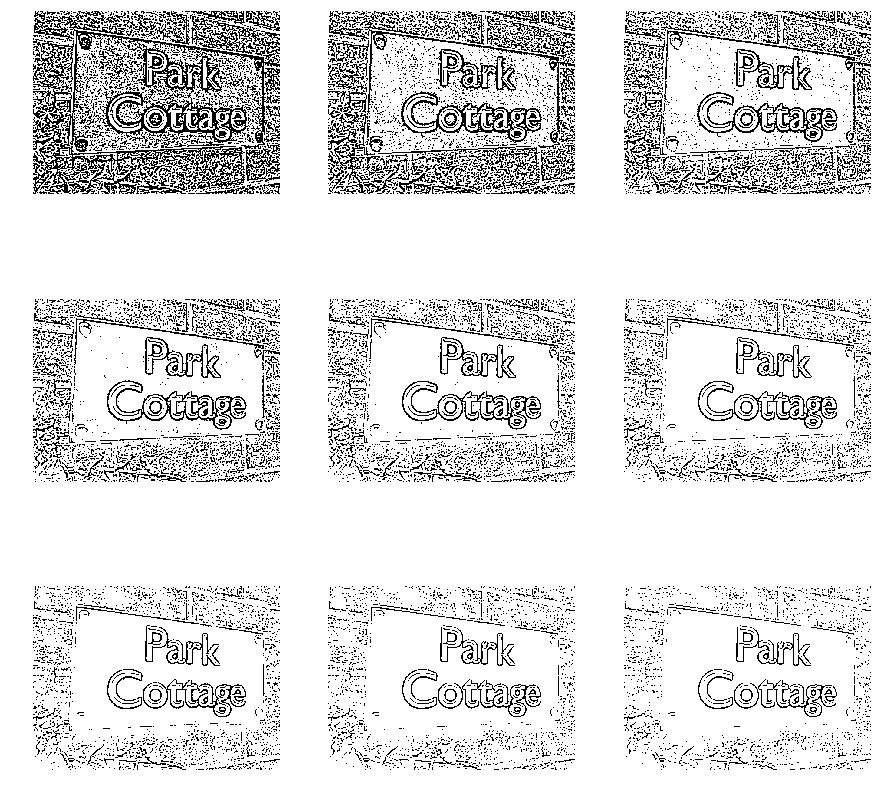

In [23]:
fig = plt.figure(figsize=(15, 15))
rows = cols = 3
for i in range(1, cols*rows +1):
    img = cv2.adaptiveThreshold(blurredImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, i)
    fig.add_subplot(rows, cols, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off')
plt.show()

The image where the plate's contour is best shown is the first one, where the constant equals 1. Now let's keep that value and vary the block size.

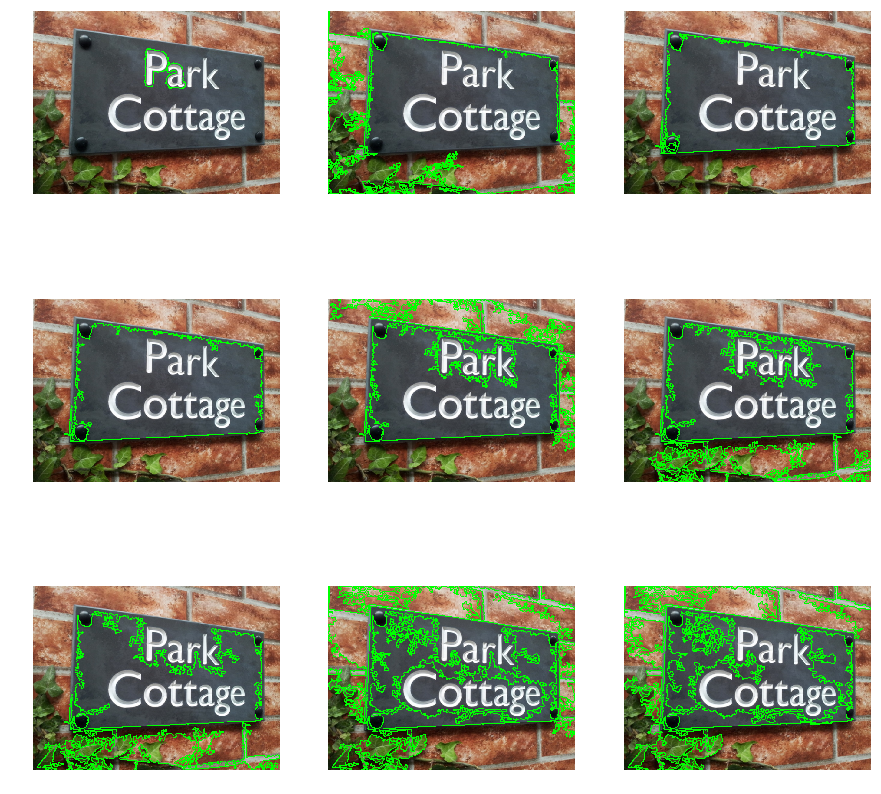

In [24]:
fig = plt.figure(figsize=(15, 15))
for i in range(1, cols*rows +1):
    img = cv2.adaptiveThreshold(blurredImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 2*i +1, 1)
    bestContour = getBestContour(img, maxVertex=30)
    regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
    croppedImg = cropImg(regularImg, bestContour)
    fig.add_subplot(rows, cols, i)
    plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off')
plt.show()

Now we can finally detect our plate by using the adaptive threshold method with block size = 9 and constant c = 1.

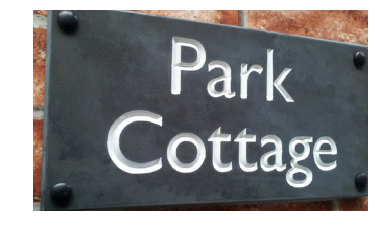

In [25]:
img = cv2.adaptiveThreshold(blurredImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 1)
bestContour = getBestContour(img, maxVertex=30)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
croppedImg = cropImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(croppedImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Just for comparison, if we were to use ADAPTIVE_THRESH_GAUSSIAN_C instead of ADAPTIVE_THRESH_MEAN_C, for the same parameters, this would be the output:

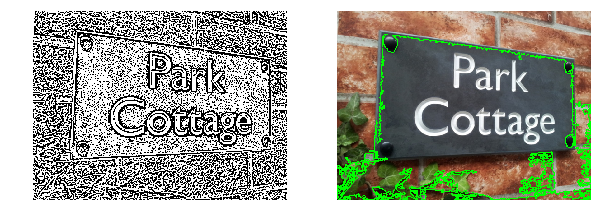

In [26]:
img = cv2.adaptiveThreshold(blurredImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 1)

bestContour = getBestContour(img, maxVertex=30)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)

rows = 1
cols = 2

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(rows, cols, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
fig.add_subplot(rows, cols, 2)
plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')

plt.show()

Now in a situation with an empty sign and a non-empty one, the script will detect the empty one, simply because it's larger. If we improve our algorithm to try to find the largest polygon with something (contours) inside, we can get the right one.

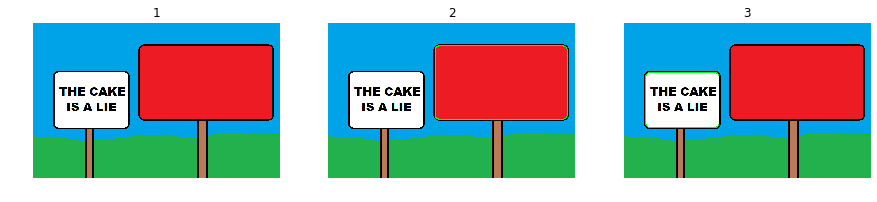

In [35]:
rows = 1
cols = 3
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(rows, cols, 1)
plt.title(1)
plt.imshow(cv2.cvtColor(cv2.imread('imgs/the_cake_is_a_lie.png'), cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

fig.add_subplot(rows, cols, 2)
plt.title(2)
croppedImg = detectPlate('imgs/the_cake_is_a_lie.png')

fig.add_subplot(rows, cols, 3)
plt.title(3)
grayImg = cv2.cvtColor(croppedImg, cv2.COLOR_BGR2GRAY);
binaryImg = getBinaryImg(grayImg)
bestContour = getBestContour(binaryImg)

if bestContour == -1:
    area = binaryImg.shape[0]*binaryImg.shape[1]
    detectPlate('imgs/the_cake_is_a_lie.png', maxArea=area);

Another interesting images

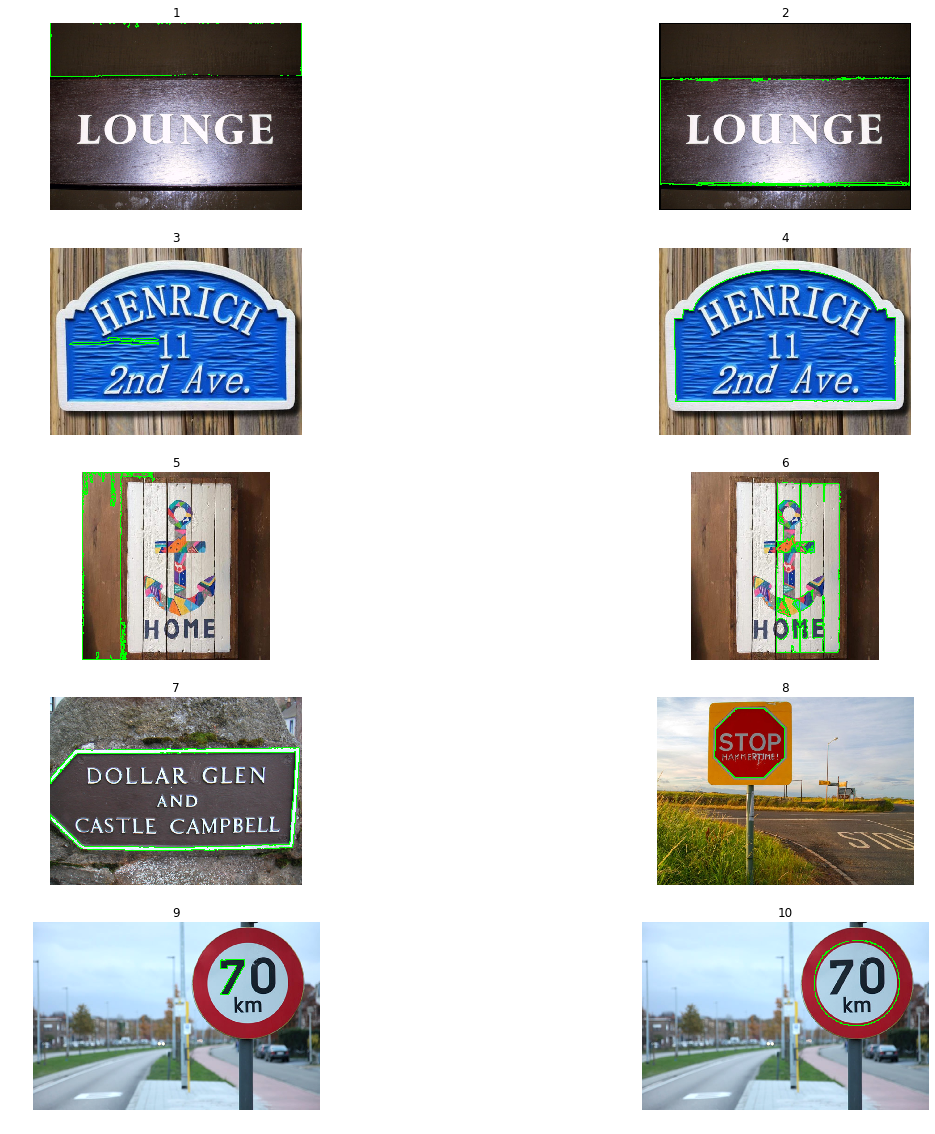

In [29]:
cols = 2
rows = 5
fig = plt.figure(figsize=(20, 20))

fig.add_subplot(rows, cols, 1)
plt.title(1)
detectPlate('imgs/231_icdar13.png');

fig.add_subplot(rows, cols, 2)
plt.title(2)
detectPlate('imgs/231_icdar13_with_fake_borders.png');

fig.add_subplot(rows, cols, 3)
plt.title(3)
detectPlate('imgs/img_1152.jpg');

fig.add_subplot(rows, cols, 4)
plt.title(4)
detectPlate('imgs/img_1152.jpg', maxVertex=20);

fig.add_subplot(rows, cols, 5)
plt.title(5)
detectPlate('imgs/img_941.jpg', maxVertex=20);

fig.add_subplot(rows, cols, 6)
plt.title(6)
detectPlate('imgs/img_941.jpg', maxVertex=100);

fig.add_subplot(rows, cols, 7)
plt.title(7)
detectPlate('imgs/302_icdar13.png');

fig.add_subplot(rows, cols, 8)
plt.title(8)
detectPlate('imgs/img_916.jpg');

fig.add_subplot(rows, cols, 9)
plt.title(9)
detectPlate('imgs/img_1196.png');

fig.add_subplot(rows, cols, 10)
plt.title(10)
detectPlate('imgs/img_1196.png', maxVertex=20);

# Brief review about the above cases

1. The top and bottom edges of the plate are easily detected, but since there are no left and right black edges, the plate is not detected.
2. Adding fake borders to the first image, the plate is now detected.
3. This is another case where the parameters change it all. On this one, we use the default maximum number of vertices of the contour, which is 15.
4. Now we change the maximum number of vertices to 20 and the plate is perfectly detected.
5. Here is an image that could not be correctly detected. Its main problem are the vertical lines between each planks, and also the anchor and the letters across those lines.
6. Now the same image, but with more vertices.
7. This is another image where the plate misses some of the border. But, in this case, since the plate's border is thick, the algorithm recognizes the white edge as a polygon, and the plate is detected.
8. This image has a small plate, comparing to the size of the image. Fortunately, the chosen method for binarization detected the clouds in the sky, so that area was not detected as a polygon. In cases where the sky is clearer, there might be some missdetections in the algorithm.
9. Due to the low number of maxVertex, the detect area was very small, comparing to the image.
10. In this case, increasing the number of vertices led to the correct recognition. Even though the sky was clear (unlike the 8th scenario), the white plate in the background confused the binarization algorithm, and that led it to consider a large part of the left side as one polygon. It's not clear if that is why the round plate was correctly detected.

# Improvements

1. In cases such as the images 5 and 6 above, one solution is to change the kernel shape of the Gaussian Blur, to make the vertical lines disappear. The same can be done for images with horizontal shapes.

PS: On the second example below, another approach is to get multiple crops of each single smaller plate

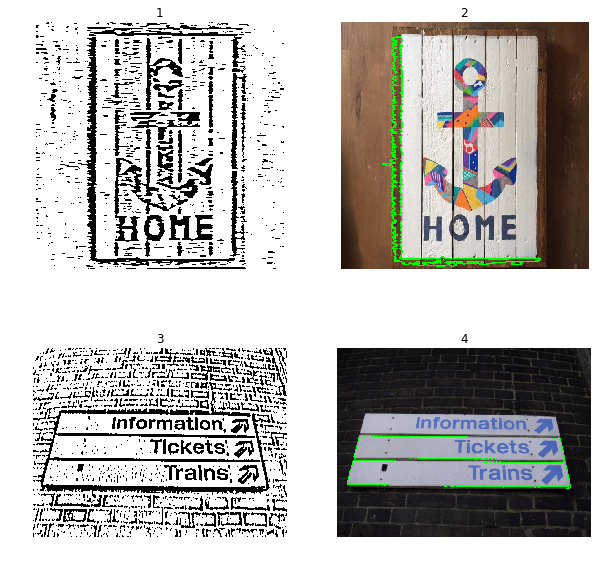

In [104]:
cols = 2
rows = 2
fig = plt.figure(figsize=(10, 10))

kernel = (31,1)

fig.add_subplot(rows, cols, 1)
plt.title(1)
detectPlate('imgs/img_941.jpg', kernel=kernel, printBinary=True)

fig.add_subplot(rows, cols, 2)
plt.title(2)
detectPlate('imgs/img_941.jpg', kernel=kernel, printBinary=False)

kernel = (5,17)

fig.add_subplot(rows, cols, 3)
plt.title(3)
detectPlate('imgs/106_icdar13.png', kernel=kernel, printBinary=True)

fig.add_subplot(rows, cols, 4)
plt.title(4)
detectPlate('imgs/106_icdar13.png', maxVertex=15, kernel=kernel, printBinary=False);

2. Automatically detect the best binarization mode

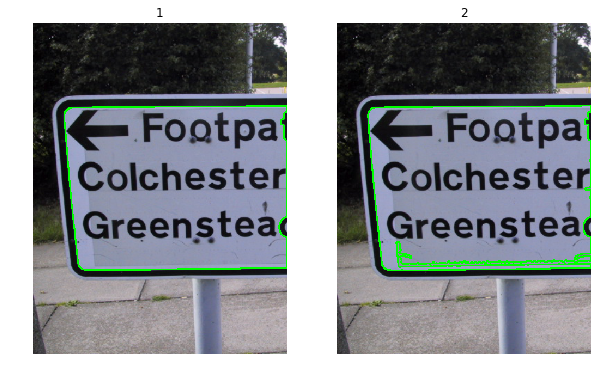

In [105]:
cols = 2
rows = 1
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(rows, cols, 1)
plt.title(1)
detectPlate('imgs/100_icdar13_cropped.png', maxVertex=14, printBinary=False, binarizationMode="mean")

fig.add_subplot(rows, cols, 2)
plt.title(2)
detectPlate('imgs/100_icdar13_cropped.png', maxVertex=14, printBinary=False, binarizationMode="adaptiveThreshold");

3. Always select the inner border in plates with multiple borders, such as the following

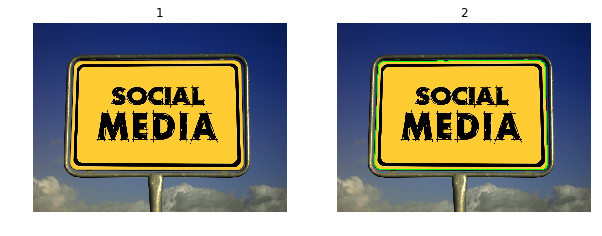

In [148]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(rows, cols, 1)
plt.title(1)
plt.imshow(cv2.cvtColor(cv2.imread('imgs/img_1106.jpg'), cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

fig.add_subplot(rows, cols, 2)
plt.title(2)
detectPlate('imgs/img_1106.jpg');

# Methods used for the script

In [34]:
'''
    Crops the image at the maximum and minimum values of the contour
'''
def cropImg(img, contour):
    img = np.copy(img)
    maxX = maxY = 0
    minX = minY = img.shape[0]
    for c in contour:
        c = c[0]
        if c[0] > maxX:
            maxX = c[0]
        elif c[0] < minX:
            minX = c[0]

        if c[1] > maxY:
            maxY = c[1]
        elif c[1] < minY:
            minY = c[1]

    crop_img = img[minY:maxY, minX:maxX]
    return crop_img

def applyBlurToImg(img, kernel=(5,5)):
    return cv2.GaussianBlur(img, kernel, 0)

def getBinaryImg(img, alpha = 1.0):
    mean = np.mean(img)
    _, binaryImg = cv2.threshold(img, mean*alpha, 255, 0)
    return binaryImg

def getBestContour(img, minVertex=0, maxVertex=15, maxArea=-1):
    # finds contours
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imgSize = img.shape[0]*img.shape[1]
    largestC = -1

    # checks if there`s a threshold to how large the area should be
    if maxArea == -1:
        maxArea = imgSize
    
    largestAreaFound = 0
    for c in contours:
        # gets area and perimeter of contour
        perimeter = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        approxPolygon = cv2.approxPolyDP(c, 0.005 * perimeter, True)
#         if len(approxPolygon) > minVertex and len(approxPolygon) < maxVertex and area > largestAreaFound and area < 0.9*imgSize and area < 0.9*maxArea:
        if len(approxPolygon) > minVertex and len(approxPolygon) < maxVertex and area > largestAreaFound and area < 0.9*maxArea:
            largestC = c
            largestAreaFound = area
    
    return largestC

'''
    [not used anymore]
    Applies all contours into the image and returns it
'''
def getContouredImg(regularImg, grayImg, minVertex=0, maxVertex=15):
    contours, hierarchy = cv2.findContours(grayImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    regularImg = np.copy(regularImg)
    
    for c in contours:
        perimeter = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        approxPolygon = cv2.approxPolyDP(c, 0.005 * perimeter, True)
        if len(approxPolygon) > minVertex and len(approxPolygon) < maxVertex and area > 4000:
            cv2.drawContours(regularImg, [c], -1, (0, 255, 0), 2)
    return regularImg

'''
    Simply draws the contour into the image with green colour
'''
def applyDetectionToImg(regularImgAux, bestContour):
    regularImg = np.copy(regularImgAux)
    cv2.drawContours(regularImg, [bestContour], -1, (0, 255, 0), 2)
    return regularImg

'''
    Does all the Image Processing steps needed to detect a sign with text,
    except for checking the content of the crop
'''
def detectPlate(imgName, maxVertex=15,
                kernel=(5,5), printBinary=False,
                binarizationMode='adaptiveThreshold',
                maxArea=-1):
    
    regularImg = cv2.imread(imgName)
    blurredImg = applyBlurToImg(regularImg, kernel=kernel)
    grayImg = cv2.cvtColor(blurredImg, cv2.COLOR_BGR2GRAY);
    
    # sets binarization mode
    if binarizationMode == 'mean':
        binaryImg = getBinaryImg(grayImg)
    else:
        binaryImg = cv2.adaptiveThreshold(grayImg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
    
    bestContour = getBestContour(binaryImg, maxVertex=maxVertex, maxArea=maxArea)
    
    regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
    
    # plots binary or regular image
    if printBinary:
        plt.imshow(binaryImg, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off');
    
    croppedImg = cropImg(regularImg, bestContour);
    
    return croppedImg